<a href="https://colab.research.google.com/github/nhquynhhh/IS403_O21_2/blob/week8_hoangmanhthang/Model/FEDformer/DXG_FEDformer_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7

In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from neuralforecast import NeuralForecast
from neuralforecast.models import FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/pre_ADA-USD.csv')

Mounted at /content/drive


In [4]:
df['unique_id'] = 'ADA'
df = df.rename(columns={'Close': 'Price'})
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].astype(float)
df = df[['unique_id', 'Date', 'Price']]
df

,unique_id,Date,Price
0,ADA,2018-03-01,0.304397
1,ADA,2018-03-02,0.293504
2,ADA,2018-03-03,0.297106
3,ADA,2018-03-04,0.300787
4,ADA,2018-03-05,0.297622
...,...,...,...
2280,ADA,2024-05-28,0.456990
2281,ADA,2024-05-29,0.450995
2282,ADA,2024-05-30,0.446581
2283,ADA,2024-05-31,0.447461


In [5]:
df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df

,unique_id,ds,y
0,ADA,2018-03-01,0.304397
1,ADA,2018-03-02,0.293504
2,ADA,2018-03-03,0.297106
3,ADA,2018-03-04,0.300787
4,ADA,2018-03-05,0.297622
...,...,...,...
2280,ADA,2024-05-28,0.456990
2281,ADA,2024-05-29,0.450995
2282,ADA,2024-05-30,0.446581
2283,ADA,2024-05-31,0.447461


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2285 non-null   object        
 1   ds         2285 non-null   datetime64[ns]
 2   y          2285 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 53.7+ KB


In [7]:
train_data = df[:int(0.8 * int(len(df)))]
test_data = df[int(0.8 * int(len(df))):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 1828
Test lenght: 457


In [42]:
model = FEDformer(h=test_len+90,
                 input_size=300,
                 modes=64,
                 hidden_size=128,
                 n_head=8,
                 scaler_type='standard',
                 learning_rate=1e-3,
                 max_steps=200,
                 batch_size=32,
                 windows_batch_size=256
                )

nf = NeuralForecast(
    models=[model],
    freq='D',
)
nf.fit(df=train_data, static_df=None, verbose=True)
forecasts = nf.predict()


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 279 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [43]:
train = train_data['y']
test = test_data['y']


train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [44]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]


In [45]:
print(predict_test.isna().sum())

0


In [46]:
predict_test

0      0.544837
1      0.476304
2      0.426414
3      0.424460
4      0.385035
         ...   
452    0.865659
453    0.836391
454    0.887751
455    0.828775
456    0.843560
Name: FEDformer, Length: 457, dtype: float32

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.47409493664195185
Mean Absolute Percentage Error (MAPE): 108.5337816502742
Root Mean Square Error (RMSE): 0.5943476713443322


In [48]:
# adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)


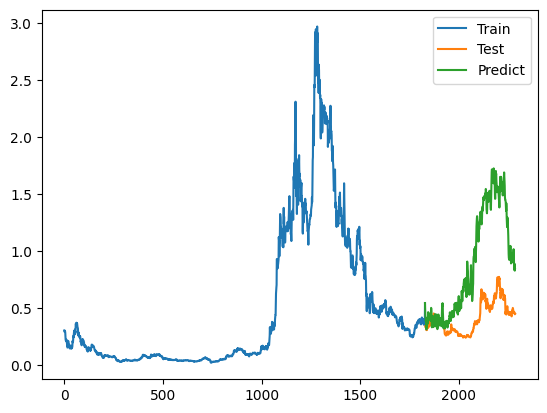

In [49]:
train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(predict_test_index,(predict_test))
plt.legend(['Train','Test','Predict'])
plt.show()



In [50]:
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]


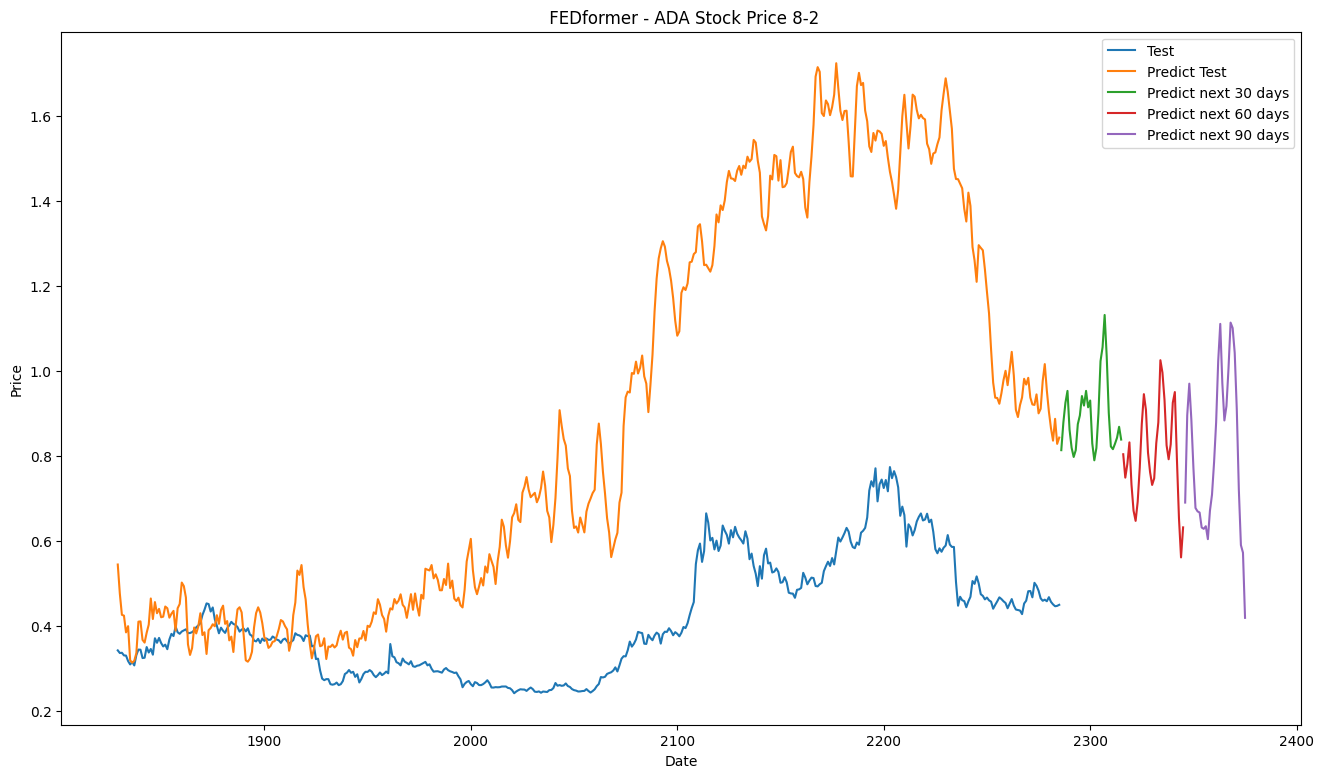

In [52]:
plt.figure(figsize=(16, 9))
# train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
# plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))
predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)
plt.legend([ 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(' FEDformer - ADA Stock Price 8-2')
plt.show()
